# IMDB Sentiment Analysis
The following model will be trained to classify movie reviews as either positive or negative. The input of this model will be reviews' text.

### Importing necessary tools

In [ ]:
import tensorflow as tf
from tensorflow import version

import numpy as np
import matplotlib.pyplot as plt

import os
import shutil  # shell utilities

import string
import re  # regular expressions

In [2]:
print("TensorFlow version: ", version.VERSION)

TensorFlow version:  2.11.0


### Downloading the dataset

If dataset is not downloaded, download and extract it:

In [3]:
if not os.path.isdir("data/aclImdb"):
    url = r"https://ai.stanford.edu/%7Eamaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file(
        fname="aclImdb_v1", origin=url,
        cache_dir="data", cache_subdir='',
        extract=True,
    )
    
    '''
    dataset          data/aclImdb_v1.tar.gz
    dataset dirname  data
    dataset joined   data/aclImdb
    '''
    dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
else:
    dataset_dir = "data/aclImdb"

os.listdir(dataset_dir)

['train', 'test', 'imdbEr.txt', 'README', '.ipynb_checkpoints', 'imdb.vocab']

Listing the directories inside of the 'train' directory and visualizing an input sample's format:

**Note**: I notice "br" tags which must be taken care of.

In [4]:
train_dir = os.path.join(dataset_dir, "train")
print(train_dir, ":\n\t" , os.listdir(train_dir), sep='', end="\n\n")
test_dir = os.path.join(dataset_dir, "test")
print(test_dir, ":\n\t" , os.listdir(test_dir), sep='', end="\n\n")

pos_dir = os.path.join(train_dir, "pos")
print(pos_dir, ":\n\t" , os.listdir(pos_dir)[:5], "...", sep='', end="\n\n")

sample_file = os.path.join(pos_dir, "7142_8.txt")
with open(sample_file, 'r') as f:
    print("Sample positive review", ":\n\t", f.read(), sep='')

data/aclImdb/train:
	['pos', 'neg', 'urls_neg.txt', 'labeledBow.feat', 'unsupBow.feat', 'urls_pos.txt', 'urls_unsup.txt']

data/aclImdb/test:
	['pos', 'neg', 'urls_neg.txt', 'labeledBow.feat', 'urls_pos.txt']

data/aclImdb/train/pos:
	['6797_8.txt', '736_10.txt', '12370_8.txt', '7142_8.txt', '1946_9.txt']...

Sample positive review:
	Holes, originally a novel by Louis Sachar, was successfully transformed into an entertaining and well-made film. Starring Sigourney Weaver as the warden, Shia Labeouf as Stanley, and Khleo Thomas as Zero, the roles were very well casted, and the actors portrayed their roles well.<br /><br />The film had inter-weaving storylines that all led up to the end. The main storyline is about Stanley Yelnats and his punishment of spending a year and a half at Camp Greenlake. The second storyline is about Sam and Kate Barlow. This plot deals with racism and it is the more deep storyline to the movie. The third is about Elya Yelnats and Madame Zeroni, which explains t

### Loading the dataset to memory:

**Note**: To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b.  Any other folders must be removed before using the `text_dataset_from_directory` utility.

Removing the extra directory "unsup" from the "train" directory if it exists:

In [5]:
if os.path.isdir("data/aclImdb/train/unsup"):
    unsup_dir = os.path.join(train_dir, "unsup")
    shutil.rmtree(unsup_dir)
    print("Deleted \"unsup\" directory.")

Dividing the raw dataset into training and validation sets using the `validation_split` argument (80:20):

In [6]:
batch_size = 32
seed = 42

# loading the training and validation sets
raw_train_ds, raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="both",
    seed=seed)
# alternatively
'''
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir, 
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)
'''

# loading the testing set
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    directory=test_dir, 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


2023-03-18 01:20:36.549711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-18 01:20:36.549725: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-18 01:20:36.549733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alrshdn): /proc/driver/nvidia/version does not exist
2023-03-18 01:20:36.549892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25000 files belonging to 2 classes.


Notice Dataset type difference:

In [7]:
raw_train_ds, raw_train_ds.take(count=1)

(<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

Iterating over the batches of BatchDataset and visualizing 3 examples from each batch:

In [8]:
for text_batch, label_batch in raw_train_ds.take(count=1):  # count is the number of batches in this BatchDataset
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Printing class names for each class label:

**Note**: These are inferred from the folder names by the `text_dataset_from_directory` utility. There are other options in the `labels` argument for naming the classes. Also, this attribute is added by the utility and does not exist in the default `Dataset` class.

In [9]:
print("Label 0:", raw_train_ds.class_names[0])
print("Label 1:", raw_train_ds.class_names[1])

Label 0: neg
Label 1: pos


### Data preparation

Text standardization, tokenization, and vectorization.

1. Standardization: preprocessing the text data by removing punctuation and HTML tags, as well as switching to lowercase characters. (Data cleansing)

2. Tokenization: splitting strings into tokens. (Feature extraction)

3. Vectorization: converting tokens into numbers.

In [10]:
def imdb_standardize(data):
    """Custom function for use in TensorFlow's TextVectorization layer."""
    
    # lowercase
    data_lowercase = tf.strings.lower(data)
    
    # removing HTML tags
    data_stripped = tf.strings.regex_replace(data_lowercase,
                                             "<br />", ' ')
    # removing punctuation
    return tf.strings.regex_replace(data_stripped,
                                    "[%s]" % re.escape(string.punctuation), '')


MAX_FEATURES = 10000

# TextVectorization layer either truncates or pads sequences of tokens
# to exactly `sequence_length` values
SEQUENCE_LENGTH = 250
# alternatively, use `tf.keras.utils.pad_sequences` for more control

# custom standardization, default splitting, 
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=imdb_standardize,
    max_tokens=MAX_FEATURES,
    output_mode="int",  # unique integer indices for each token.
    output_sequence_length=SEQUENCE_LENGTH)

Fitting the preprocessing layer to the training data to build an index of strings to integers (vocabulary/dictionary):

**Note**: It's important to only use the training data when calling adapt (using the test set would leak information).

In [11]:
# removing the `label_batch` and keeping the `text_batch` to adapt the preprocessing layer to it
train_text = raw_train_ds.map(lambda x, y: x)

vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Testing the preprocessing layer on sample data:

In [12]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# a batch from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
review_0, label_0 = text_batch[0], label_batch[0]
print("Review", ":\n", review_0, sep='', end="\n\n")
print("Label", ":\n", raw_train_ds.class_names[label_0], sep='', end="\n\n")

print("Vectorized review", ":\n", vectorize_text(review_0, label_0), sep='')

Review:
tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)

Label:
neg

Vectorized review:
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
  

Looking up a string token that an integer corresponds to:

In [13]:
vectorize_layer_vocab = vectorize_layer.get_vocabulary()
print("index 101 corresponds to string token:", vectorize_layer_vocab[101])
print("index 249 corresponds to string token:", vectorize_layer_vocab[249])
print("index 9999 corresponds to string token:", vectorize_layer_vocab[9999])

print("Vocabulary size =", len(vectorize_layer_vocab), "indices")  # `max_tokens`

index 101 corresponds to string token: after
index 249 corresponds to string token: making
index 9999 corresponds to string token: rushes
Vocabulary size = 10000 indices


Preprocessing the training, validation, and testing sets:

In [14]:
# remember that the datasets have two inputs to be mapped,
# thus why `vectorize_text` takes two arguments: `text`, and `label`
# and returns `label` unchanged.

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Making sure I/O does not become a bottleneck while training by caching the datasets:

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating, compiling, and training the model

In [16]:
EMBEDDING_DIM = 24

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_FEATURES + 1, EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 24)          240024    
                                                                 
 dropout (Dropout)           (None, None, 24)          0         
                                                                 
 global_average_pooling1d (G  (None, 24)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 240,049
Trainable params: 240,049
Non-trainable params: 0
__________________________________________________

In [17]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS)

Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6531 - binary_accuracy: 0.7063 - val_loss: 0.5876 - val_binary_accuracy: 0.7844
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5108 - binary_accuracy: 0.8174 - val_loss: 0.4574 - val_binary_accuracy: 0.8348
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4032 - binary_accuracy: 0.8576 - val_loss: 0.3853 - val_binary_accuracy: 0.8572
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3426 - binary_accuracy: 0.8748 - val_loss: 0.3466 - val_binary_accuracy: 0.8674
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3042 - binary_accuracy: 0.8888 - val_loss: 0.3237 - val_binary_accuracy: 0.8724
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.2770 - binary_accuracy: 0.8982 - val_loss: 0.3091 - val_binary_accuracy: 0.8732
Epoch 7/10
625/625 [==============================] - 1s 2ms/ste

Evaluating the model:

In [18]:
loss, acc = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", acc)

782/782 [==============================] - 1s 739us/step - loss: 0.3078 - binary_accuracy: 0.8743
Loss:  0.30777454376220703
Accuracy:  0.8742799758911133


### Visualizing

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Plotting loss:

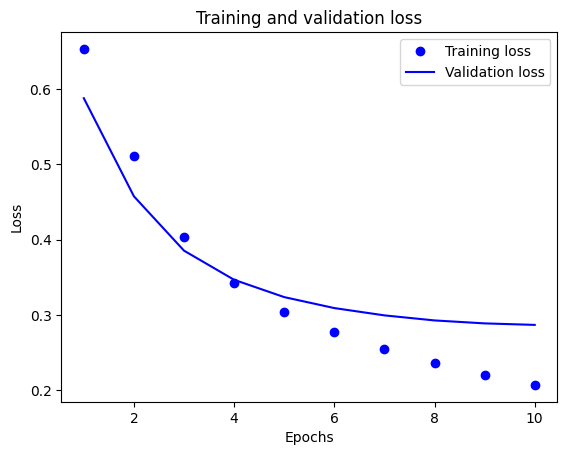

In [20]:
loss = history_dict["loss"]
val_loss = history_dict['val_loss']

epochs = np.arange(1, EPOCHS + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Plotting accuracy:

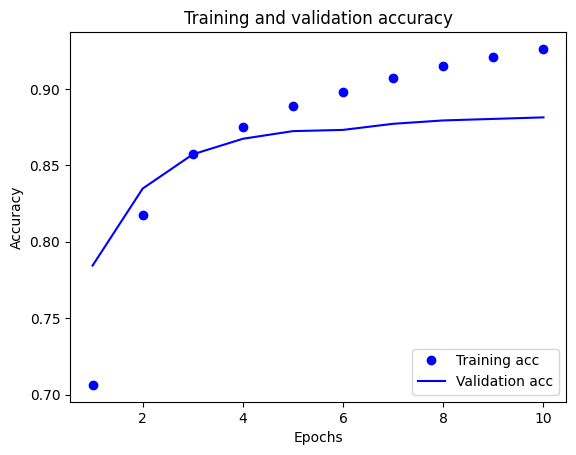

In [21]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [24]:
p = vectorize_layer(["The best movie ever. I love it so much."])
n = vectorize_layer(["The worst movie ever. I hate it so much."])

print("Positive review prediciton:", float(model.predict(p)))
print("Negative review prediciton:", float(model.predict(n)))

1/1 [==============================] - 0s 11ms/step
Positive review prediciton: 0.6602923274040222
1/1 [==============================] - 0s 9ms/step
Negative review prediciton: -1.021937608718872
